# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [35]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [36]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [37]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [8]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                          
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [9]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

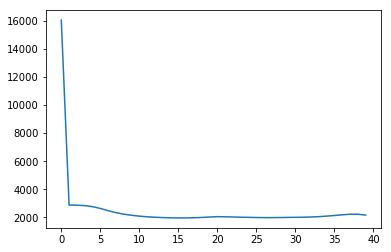

In [11]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [14]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word,)
    print  ()

sbj0: 
который
быть
что
это
человек
этот
как
свой
для
они
его
весь
такой
время
себя

sbj1: 
a
множитель
возведение
b
скобка
x
раскладывать
умножение
сокращенный
разложение
ответ
квадрат
слагаемое
многочлен
выражение

sbj2: 
обособление
куприн
слово
раскольников
мастер
роман
словосочетание
маргарита
подчинительный
соня
оборот
вера
браслет
старик
сантьяго

sbj3: 
который
быть
год
свой
время
государство
человек
мир
становиться
жизнь
северный
первый
война
африка
ребенок

sbj4: 
x
a
b
уравнение
дробь
квадратный
y
степень
функция
число
f
решение
корень
c
пример

sbj5: 
быть
год
пушкин
функция
свой
его
русский
который
поэт
империя
культура
весь
a
f
трение

sbj6: 
сила
быть
тело
энергия
поле
при
магнитный
точка
географический
наречие
если
частица
например
заряд
величина

sbj7: 
который
что
это
как
человек
для
этот
такой
быть
являться
мочь
себя
она
его
свой

sbj8: 
который
быть
что
это
свой
как
этот
человек
для
x
они
такой
государство
a
весь

sbj9: 
который
быть
что
этот
это
как
человек
свой
дл

Давайте посмотрим также на разреженность матриц:

In [16]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333064165476116
0.1653361344537815


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [17]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [18]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [20]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word,)
    print()

sbj0: 
который
быть
что
это
этот
как
человек
свой
для
они
весь
такой
его
время
год

sbj1: 


KeyError: 'sbj1'

In [22]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8168084974222002
0.3025210084033613


Попробуем менять коэффициент регуляризации:

In [23]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [24]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [25]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word,)
    print()

sbj0: 
предложение
вода
корень
древний
квадратный
дом
n
океан
жить
собственный
крестьянин
член
александр
зона
достигать

sbj1: 


KeyError: 'sbj1'

In [26]:
# еще раз посмотрим на разреженность
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9105037579973911
0.48487394957983193


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [27]:
model_artm.save("my_model")

In [28]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [29]:
phi = model_artm.get_phi()

In [30]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000011
институт,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.001560,0.000000
машинка,0.00000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
прочий,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000092
навязнуть,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000581,0.000000,0.000000
физиология,0.00000,0.0,0.0,0.000000,0.0,0.000413,0.0,0.000000,0.000000,0.000000
истязать,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000050,0.000000
выборы,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000906,0.000000
кндр,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000034
федерализм,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000050,0.000000


Матрица вероятностей тем в документах.

In [31]:
theta = model_artm.get_theta()
theta

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
sbj0,0.063670,0.033557,0.096639,0.055147,0.082840,0.040541,0.025397,0.038462,0.076923,0.064516,...,0.029536,0.174274,0.104575,0.183099,0.095071,0.097276,0.104317,0.133333,0.033210,0.076023
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.018727,0.030201,0.042017,0.044118,0.011834,0.013514,0.003175,0.019231,0.006689,0.004032,...,0.033755,0.199170,0.235294,0.098592,0.045775,0.136187,0.107914,0.051852,0.040590,0.000000
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.033708,0.050336,0.008403,0.007353,0.026627,0.018018,0.003175,0.025324,0.010033,0.322581,...,0.004219,0.045643,0.026144,0.049296,0.028169,0.031128,0.064748,0.040741,0.003834,0.005848
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.134733,0.004149,0.045729,0.017606,0.007042,0.042802,0.010791,0.011111,0.242995,0.040936
sbj8,0.352060,0.261745,0.256303,0.327206,0.239645,0.369370,0.815874,0.230769,0.217392,0.278226,...,0.076238,0.107884,0.078454,0.102113,0.112676,0.070039,0.075540,0.266667,0.037304,0.467836
sbj9,0.531835,0.624161,0.596638,0.566176,0.639053,0.558558,0.152381,0.686214,0.688963,0.330645,...,0.721519,0.468880,0.509804,0.549295,0.711267,0.622568,0.636690,0.496296,0.642066,0.409357


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [32]:
theta_test = model_artm.transform(batch_vectorizer)